# Data challenge
### Thomas J. Duignan

#### In this notebook, we will be looking at the raw data sets from the:

## Medicare Part D Prescriber Public Use File and Summary Provider Data

#### which is hosted at:

##### https://www.cms.gov/Research-Statistics-Data-and-Systems/Statistics-Trends-and-Reports/Medicare-Provider-Charge-Data/Part-D-Prescriber.html

#### Between the years 2013-2015

To reproduce this notebook, you must download the data sets yourself 
and define dictionaries of {year: path} pointing to the tsv files:
- <b>dpaths</b> (detailed files) 
- <b>spaths</b> (summary data) 

### Additionally, we will pull data from the Bureau of Labor Statistics and the US Census Bureau

- BLS: https://www.bls.gov/cew/cewedr10.htm
- Census Bureau: https://api.census.gov/data/2013/pep/subcty/examples.html

#### Required Legalese: "This product uses the Census Bureau Data API but is not endorsed or certified by the Census Bureau."

In [1]:
%matplotlib inline
from preamble import *

#### Sub-county resolution population data (not used in current analysis, but stcodes still useful)

In [2]:
# Webpage containing states and state abbreviations from Bureau of Labor Statistics
stcodes = requests.get(bls_url).text.split('table')
# Keep only the HTML table from the page and read into a dataframe
stcodes = pd.read_html('<table><tbody' + stcodes[6].split('tbody')[1] + 'tbody></table>')[0]
# Reformat it so it is one state per row
cols = {3: 0, 4: 1, 5: 2}
stcodes = pd.concat([stcodes[[0, 1, 2]], stcodes[[3, 4, 5]].rename(columns=cols)])
# Drop headers and NaNs, set index to state abbrs., and make a map of enums.
usecodes = stcodes.drop(0).dropna().set_index(0)[1].to_dict()
stcodes = stcodes.drop(0).dropna().set_index(1)[2].to_dict()

# state_pops = {} # state: pd.DataFrame of sub-county populations
# failed = {}     # Catches Puerto Rico and the Virgin Islands
# for key, stcode in stcodes.items():
#     req = requests.get(sturl.format(burl=burl, 
#                                     year=YEAR, 
#                                     stname=stcode,
#                                     query=query('for=place:*&in=state:'),
#                                     key=os.environ['CENAPI']))
#     try: state_pops[key] = pd.read_json(req.text)
#     except: failed[key] = req

# By the Year 
#### For the raw prescriber data we must work one year at a time

In [9]:
YEAR = 2013
legal = ['CA', 'NV', 'WA', 'OR', 'CO', 'ME', 'VT', 'MA']
illegal = ['ID', 'SD', 'NE', 'KS']

In [4]:
burl = 'https://api.census.gov/data'                        # Base URL
query = 'pep/subcty?get=NAME,STNAME,CTYNAME,POP&{}'.format  # Query format
naturl = '{burl}/{year}/{query}*&DATE=6&key={key}'          # State-wide resolution
sturl = '{burl}/{year}/{query}{stname}&DATE=6&key={key}'    # Sub-county resolution

### Census populations to normalize Medicare Part D data

In [5]:
stpopyears = {}
for YEAR in range(2013, 2015):
    req = requests.get(naturl.format(burl=burl, 
                                    year=YEAR, 
                                    stname=stcodes['NY'],
                                    query=query('for=state:'),
                                    key=os.environ['CENAPI']))
    stpops = pd.read_json(req.text)
    stpops.drop([0, 2, 4], axis=1, inplace=True)
    stpops.columns = stpops.loc[0]
    stpops.drop(0, inplace=True)
    stpops['POP'] = stpops['POP'].astype(np.int64)
    stpops['state'] = stpops['state'].astype(np.int64)
    stpops = stpops.sort_values(by='POP', ascending=False)
    stpops['ST'] = stpops['STNAME'].map(usecodes)
    stpopyears[YEAR] = stpops

In [6]:
stpops = stpopyears[2013]

## For the detailed public use data, deal with one year at a time

In [8]:
df13 = pd.read_csv(dpaths[2013], sep='\t')

In [10]:
mjs = df13[df13['generic_name'].isin(mjps)].groupby('nppes_provider_state')

In [11]:
df13.head()

,npi,nppes_provider_last_org_name,nppes_provider_first_name,nppes_provider_city,nppes_provider_state,specialty_description,description_flag,drug_name,generic_name,bene_count,...,total_30_day_fill_count,total_day_supply,total_drug_cost,bene_count_ge65,bene_count_ge65_suppress_flag,total_claim_count_ge65,ge65_suppress_flag,total_30_day_fill_count_ge65,total_day_supply_ge65,total_drug_cost_ge65
0,1003000126,ENKESHAFI,ARDALAN,CUMBERLAND,MD,Internal Medicine,S,ISOSORBIDE MONONITRATE ER,ISOSORBIDE MONONITRATE,NaN,...,11.0,307,171.59,NaN,*,NaN,*,NaN,NaN,NaN
1,1003000126,ENKESHAFI,ARDALAN,CUMBERLAND,MD,Internal Medicine,S,LEVOFLOXACIN,LEVOFLOXACIN,26.0,...,26.0,165,227.10,15.0,NaN,15.0,NaN,15.0,106.0,159.72
2,1003000126,ENKESHAFI,ARDALAN,CUMBERLAND,MD,Internal Medicine,S,LISINOPRIL,LISINOPRIL,17.0,...,19.0,570,100.37,NaN,#,NaN,#,NaN,NaN,NaN
3,1003000126,ENKESHAFI,ARDALAN,CUMBERLAND,MD,Internal Medicine,S,METOPROLOL TARTRATE,METOPROLOL TARTRATE,28.0,...,31.0,916,154.65,NaN,#,NaN,#,NaN,NaN,NaN
4,1003000126,ENKESHAFI,ARDALAN,CUMBERLAND,MD,Internal Medicine,S,PREDNISONE,PREDNISONE,14.0,...,14.0,133,44.72,NaN,*,NaN,*,NaN,NaN,NaN


In [16]:
s13 = []
for st, pop in zip(stpops['ST'], stpops['POP']):
    grp = mjs.get_group(st)
    s13.append((st, grp.shape[0] / pop, grp['total_day_supply'].sum() / pop))
s13 = pd.DataFrame(s13, columns=('state', 'count', 'supply')
                  ).sort_values(by='supply', ascending=False).reset_index(drop=True)

In [17]:
s13[s13['state'].isin(illegal)]

,state,count,supply
2,KS,0.000012,0.010120
20,ID,0.000012,0.004922
25,NE,0.000006,0.004596
30,SD,0.000006,0.003901


#### Very strange that KS has the 3rd highest total population normalized prescription supply count out of all states

In [18]:
s13[s13['state'].isin(legal)]

,state,count,supply
6,ME,0.000014,0.007507
9,NV,0.000010,0.006589
13,VT,0.000013,0.005952
14,CA,0.000009,0.005607
18,OR,0.000010,0.005134
29,WA,0.000008,0.003905
36,MA,0.000008,0.003194
43,CO,0.000005,0.002362


#### Less surprising that CO ranks 44th due to recreational legality, less prescriptions are needed as people self-medicate legally?

#### Direct comparison between prescription marijuana and prescription opioids difficult in the detailed data due to the low abundance of prescriptions of marijuana in this Medicare Part D Prescriber data set

## For the prescriber summary data we can deal with all the years at once

#### Read in the summary data first

In [19]:
sumdfs = {year: pd.read_csv(spaths[year], sep='\t') for year in range(2013, 2017)}

#### Use the zip codes to obtain geo-coding data from the Census Bureau for future location-based correlations (writes a bunch of data files to be fed into the geo-coding API)

In [21]:
sumdf13 = sumdfs[2013]
smdf13 = sumdf13[~pd.isnull(sumdf13['nppes_provider_zip5'])]
tocsv = smdf13[['nppes_provider_street1', 
                'nppes_provider_city', 
                'nppes_provider_state',
                'nppes_provider_zip5']]
for i, ch in enumerate(range(0, tocsv.shape[0] + 1, 9000)):
    tocsv.loc[ch:ch+8999].to_csv('addresses-13-{:03d}.csv'.format(i), header=None)

#### Geocoding services batch submission using a script along the lines of:


```
#!/bin/bash

printf -v i "%03d" $1

curl --form addressFile=@addresses-13-$i.csv 
     --form benchmark=9 https://geocoding.geo.census.gov/geocoder/locations/addressbatch 
     --output addresses-13-$i-out.csv
```


#### And check that we receive results that make sense (I .gitignored csv's so this file is not present on github)

In [22]:
codemap = pd.read_csv('addresses-13-000-out.csv', header=None, names=range(8))[[0, 5]].set_index(0)[5]#.to_dict()
codemap.head()

0
6873                     NaN
6874                     NaN
6871     -74.17845,39.986805
6872      -75.00766,39.83061
6870    -88.071365,41.876778
Name: 5, dtype: object

#### Can't find all addresses with exact match but matches about 85% so should be enough for a nationwide visualization
#### More to come here after geocoding has completed (slow process ~25 hours per year)

### On to analysis of summary data

#### First a time series of the ratio of the percentage of opioid prescriptions relative to the total number of prescriptions by state from the years 2013-2015

In [23]:
tseries = []
for i, (year, sumdf) in enumerate(sumdfs.items()):
    # Summary by state
    grps = sumdf.groupby('nppes_provider_state')
    # Filter out non-contiguous 48 (for simplicity)
    contig = set(stpops['ST'].unique())
    adf = []
    for st, pop in zip(stpops['ST'], stpops['POP']):
        grp = grps.get_group(st)
        adf.append((st, grp['total_claim_count'].sum() / pop,
                        grp['opioid_claim_count'].sum() / pop,
                        grp['other_claim_count'].sum() / pop))


    adf = pd.DataFrame(adf, columns=('state', 'frac_claims', 
                                     'frac_opioid', 'frac_other')
                      ).sort_values(by='state')
    adf['op/tot'] = adf['frac_opioid'] / adf['frac_claims'] * 100
    if not i: tseries.append(adf['state'])
    tseries.append(pd.Series(adf['op/tot'], name=year))
tseries = pd.concat(tseries, axis=1).set_index('state').T

In [24]:
tseries

state,AK,AL,AR,AZ,CA,CO,CT,DC,DE,FL,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
2013,6.753564,7.751064,6.732789,6.983226,5.482245,7.521128,4.517460,4.328451,6.585200,5.217623,...,5.195356,7.381923,6.096445,7.707354,5.965193,5.925974,6.983884,5.910689,6.544222,5.955627
2014,6.761236,7.857454,6.632601,6.991193,5.463093,7.384083,4.499954,4.329028,6.521197,5.263576,...,5.230928,7.338833,5.969657,7.802159,5.850654,5.950290,7.083791,5.950908,6.353813,6.183223
2015,6.663950,7.541998,6.366999,6.784156,5.191149,7.243649,4.293823,4.122831,6.318913,5.168996,...,5.104564,7.159598,5.521190,7.616866,5.562179,5.659713,6.905457,5.812019,5.807621,6.187701
2016,6.737548,7.466564,6.368262,6.513290,5.017909,7.016356,4.063928,3.907378,5.936770,5.193969,...,5.031086,6.969615,5.452617,7.464726,5.306485,5.407276,6.652142,5.538676,5.267729,5.905270


#### Let's just see whether this data makes any sense

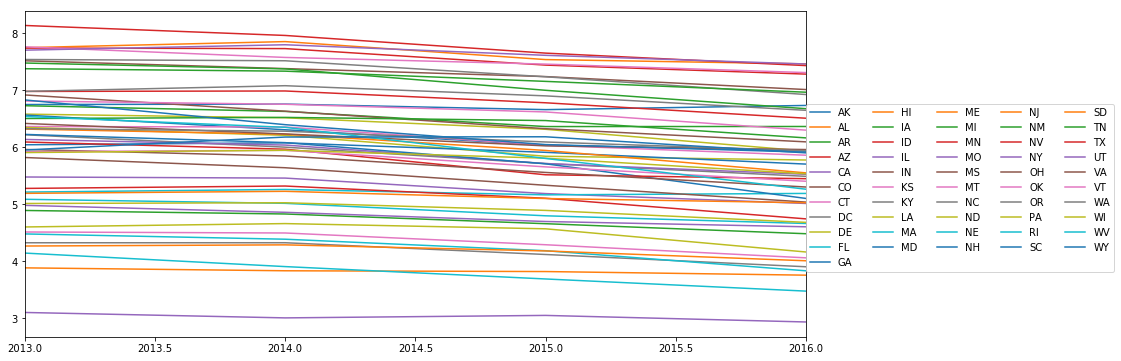

In [25]:
fig = sns.mpl.pyplot.figure(figsize=(14, 6))
ax = fig.add_subplot(111)
tseries.plot(ax=ax, legend=False)
sns.mpl.pyplot.legend(loc=(1.0, 0.2), ncol=5)

####  Okay the percentage of opioid prescription claims to total claims by Medicare Part D prescribers appears to be decreasing over time, will a linear model tell us more?

In [26]:
from sklearn import linear_model as lm
from collections import defaultdict
import statsmodels.api as sm
import scipy.stats as scs

/home/tjduigna/miniconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [27]:
regdf = []
predicty = {}
dummy = np.ones(26)
predictx = np.linspace(2000, 2025, 26)
predictx = np.array(list(zip(dummy, predictx)))
mod = lm.LinearRegression()
for state in tseries:
    yint = sm.add_constant(tseries[state].index.values)
    res = mod.fit(yint, tseries[state].values)
    predicty[state] = res.predict(predictx)
    regdf.append((state, res.coef_[0], res.coef_[1], res.intercept_))
regdf = pd.DataFrame(regdf, columns=('state', 'coef0', 'coef1', 'intercept'))

In [28]:
extrap = pd.DataFrame.from_dict(predicty)

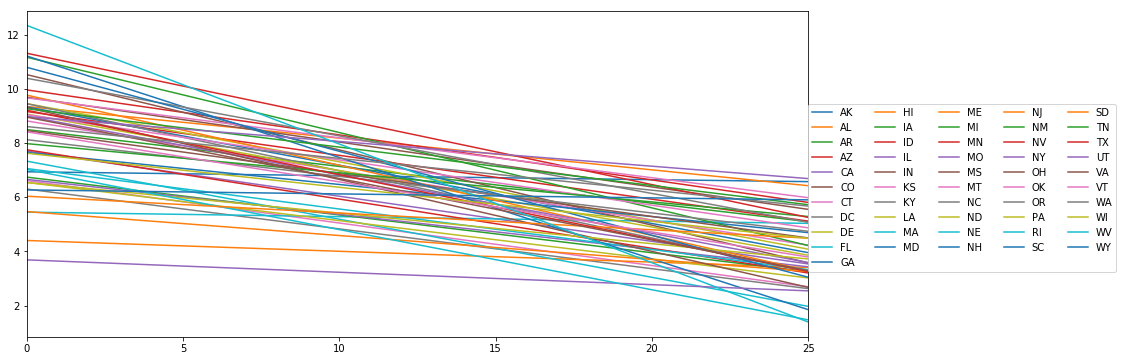

In [29]:
fig = sns.mpl.pyplot.figure(figsize=(14, 6))
ax = fig.add_subplot(111)
extrap.plot(ax=ax, legend=False)
sns.mpl.pyplot.legend(loc=(1.0, 0.2), ncol=5)

#### Surely with only 4 data points (years), extrapolating too far will get us in trouble.  Are there any outliers in the slopes of these models?

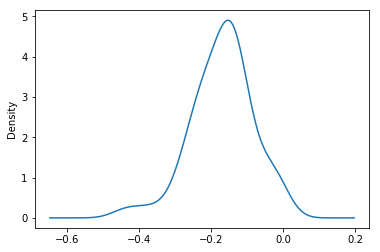

In [30]:
regdf.coef1.plot.kde()

#### This certainly doesn't look quite like a normal distribution as there are shoulders on each side

In [39]:
opp = regdf.sort_values(by='coef1').reset_index(drop=True)
opp.head()

,state,coef0,coef1,intercept
0,WV,0.0,-0.437567,887.472287
1,NH,0.0,-0.374242,759.694863
2,SC,0.0,-0.309749,630.289936
3,MI,0.0,-0.277860,566.885214
4,IN,0.0,-0.277621,565.763642


#### The most interesting thing about this is that West Virginia has the highest overdose death rate in the country since 2014, according to the Centers for Disease Control

https://www.cdc.gov/drugoverdose/data/statedeaths.html  WV ranks #1, NH ranks #3

However, these 2 states have seen the largest decrease in the percentage of opioid prescriptions between 2013-2016.  Perhaps as a direct response to the increased attention, states with the largest problems are aggressively reducing the rate of opioid prescription

In [41]:
opp[opp['state'].isin(illegal)]

,state,coef0,coef1,intercept
19,KS,0.0,-0.183135,375.083227
23,ID,0.0,-0.165979,341.916895
28,NE,0.0,-0.149231,305.519704
45,SD,0.0,-0.061917,129.872996


#### States where medical marijuana is illegal are in the lower 50% of reduction in opioid prescription, if we omit Kansas as an outlier (which we saw in the beginning may be valid) 

In [42]:
opp[opp['state'].isin(legal)]

,state,coef0,coef1,intercept
6,ME,0.0,-0.258838,527.443417
8,NV,0.0,-0.242214,495.740334
15,MA,0.0,-0.214227,435.786118
16,OR,0.0,-0.212432,435.252502
18,VT,0.0,-0.184667,377.747477
22,CA,0.0,-0.166495,340.693240
24,CO,0.0,-0.165475,340.640936
39,WA,0.0,-0.117356,243.319895


#### Some states, ME and NV, where recreational marijuana is already legal are also seeing the larger decreases in the percentage of opioid prescriptions, with most of them in the top 50% of reduction, except for Washington

In [8]:
# total = 24000000
# chnksz = 10000
# for j, (year, path) in enumerate(dpaths.items()):
#     years.value = j / 3
#     for i, chnk in enumerate(pd.read_csv(path, sep='\t', 
#                                          chunksize=chnksz)):
#         chnks.value = chnk.index[0] / total
#         chnk['year'] = year
#         chnk.to_sql('partd', con=eng, if_exists='append')
# years.value = 1